In [1]:
data_fp = '/home/theo/research/courses/12.843/data' # path for data
figs_fp = '/home/theo/research/courses/12.843/figs' # path to save figs

In [2]:
import xarray as xr
import scipy.io as sio
from scipy.fft import fft, ifft
from matplotlib.path import Path
import pickle
from scipy.stats import pearsonr
from os.path import join
import numpy as np
from glob import glob
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import pandas as pd
from copy import deepcopy
from progressbar import progressbar
import gen_utils
import seaborn
seaborn.set()
    
### Specify figure resolution
scale = 1
mpl.rcParams['figure.dpi']        = 300 # set figure resolution (dots per inch) 
mpl.rcParams['hatch.linewidth']   = .15  * scale
mpl.rcParams['axes.labelsize']    = 11  * scale
mpl.rcParams['axes.titlesize']    = 13  * scale
mpl.rcParams['xtick.labelsize']   = 9   * scale
mpl.rcParams['ytick.labelsize']   = 9   * scale
mpl.rcParams['lines.linewidth']   = 1   * scale
mpl.rcParams['legend.fontsize']   = 8   * scale
mpl.rcParams['patch.linewidth']   = 1   * scale
mpl.rcParams['contour.linewidth'] =.5   * scale
mpl.rcParams['axes.labelpad']     = 4 * scale   # space between label and axis
mpl.rcParams['xtick.major.pad']   = 0 * scale   # distance to major tick label in points
mpl.rcParams['ytick.major.pad']   = mpl.rcParams['xtick.major.pad']
mpl.rcParams['lines.markersize']  = 3 * scale

### cartopy-specific parameters
gridline_width                    = .7 * scale
border_width                      = .3 * scale

### manually specified colorbar params
tick_width                        = 0 * scale # controls size of tickmark next to labels
tick_length                       = 2 * scale

# Tracking

In [3]:
d = xr.open_dataset(join(data_fp, 'IBTrACS.ALL.v04r00.nc'))

irwin_data  = d.sel(storm=d.name==b'IRWIN').isel(storm=-1).compute()
hilary_data = d.sel(storm=d.name==b'HILARY').isel(storm=-1).compute()

hilary_data = hilary_data.isel(date_time=np.arange(0,94,2))
irwin_data = irwin_data.isel(date_time=np.arange(0,100,2))

# Animations

$\zeta = \frac{1}{R\cos{\theta}}\Big[\frac{\partial}{\theta}\left(u\cos{\theta}\right) - \frac{\partial v}{\partial \phi}\Big]$

Load data and convert to polar coords

In [52]:
u = xr.open_dataset(join(data_fp,'era5_u_843.nc')).u.sel(latitude=slice(50,0),
                                                         longitude=slice(220,260)).compute()
v = xr.open_dataset(join(data_fp,'era5_v_843.nc')).v.sel(latitude=slice(50,0),
                                                         longitude=slice(220,260)).compute()

## Convert to polar coords
lon            = deepcopy(u.longitude) # copy of original coords for plotting
lat            = deepcopy(u.latitude)
theta          = np.deg2rad(u.latitude).values
phi            = np.deg2rad(u.longitude).values
u              = u.rename({'longitude':'phi', 'latitude':'theta'})
v              = v.rename({'longitude':'phi', 'latitude':'theta'})
u['phi']       = phi
v['phi']       = phi
u['theta']     = theta
v['theta']     = theta

Compute vorticity

In [53]:
R     = 6.37e6
omega = 7.29e-5 
f     = 2*omega * np.sin(u['theta'])

## Relative vorticity
dv_dphi             = -v.differentiate('phi')
u_cos_theta         =  u * np.cos(u['theta'])

dtheta_du_cos_theta = -u_cos_theta.differentiate('theta')
zeta                = 1 / (R*np.cos(u['theta'])) * (dtheta_du_cos_theta - dv_dphi)

## Absolute vorticity
eta                 = zeta + f

Plot

In [6]:
time = pd.date_range(start='2017-07-20', periods=59,freq='6h')[2:]
stormnames=['hilary','irwin']
varnames = ['lon','lat']
arr  = np.nan * np.zeros([len(time), len(stormnames), len(varnames)])

arr[:len(hilary_data.date_time), 0,0] = hilary_data.lon
arr[:len(hilary_data.date_time), 0,1] = hilary_data.lat
arr[-len(irwin_data.date_time):, 1,0] = irwin_data.lon
arr[-len(irwin_data.date_time):, 1,1] = irwin_data.lat

arr = xr.DataArray(arr, dims=['time','storm','var_'], coords={'time':time,'storm':stormnames,'var_':varnames})

In [27]:
def plot_frame(ti, lev=0):
    scale_fac = 1e4
    figsize=(8,4)
    fig = plt.figure(figsize=figsize)
#     ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
    ax = fig.add_subplot(projection=ccrs.Orthographic(central_longitude=250, central_latitude=20))
    ax.set_extent([225,260,5,30], crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=border_width)
    ax.add_feature(cfeature.BORDERS, zorder=1, linewidth = border_width)
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=.1, linewidth=gridline_width, color='k', zorder=1.05)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': mpl.rcParams['xtick.labelsize']}
    gl.ylabel_style = {'size': mpl.rcParams['ytick.labelsize']}
    
#     cp = ax.contour(lon,lat, scale_fac * eta.isel(time=ti, level=1), extend='both',  colors='k',
#                       levels=np.arange(0,1e1+2e0,2e0),transform=ccrs.PlateCarree())

    cp1 = ax.contourf(lon,lat, scale_fac * eta.isel(time=ti, level=lev), extend='both',  cmap='cmo.amp', 
                      levels=np.arange(0,1e1+1e0,1e0),transform=ccrs.PlateCarree())
    cb = fig.colorbar(cp1, fraction=.02)
    cb.set_label("$10^{-4}$ s$^{-1}$")
    
    mo = eta.time.isel(time=ti).dt.month.values.item()
    da = eta.time.isel(time=ti).dt.day.values.item()
    ho = eta.time.isel(time=ti).dt.hour.values.item()
#     title = r'$f+\zeta$, on ' + f'{mo:02d}/{da:02d}, {ho:02d}:00'
    title = r'Storm centers, on ' + f'{mo:02d}/{da:02d}, {ho:02d}:00'
    ax.set_title(title)

    #### Quiver plot
    n=7
    x,y = np.meshgrid(lon[::n].values, lat[::n].values)
    qv = ax.quiver(x,y, u.isel(time=ti, level=lev).values[::n,::n], 
                   v.isel(time=ti, level=lev).values[::n,::n], 
                   scale=.5e3, color='black', alpha=.6, transform=ccrs.PlateCarree(), pivot='middle')
    
    for s in ['hilary','irwin']:
        ax.scatter(*[arr.isel(time=ti-2).sel(storm=s,var_=l).values.item() for l in ['lon','lat']],
                  color='k', marker='o',transform=ccrs.PlateCarree(), s=7)
    ax.plot([arr.isel(time=ti-2).sel(storm=s,var_='lon').values.item() for s in ['hilary','irwin']],
            [arr.isel(time=ti-2).sel(storm=s,var_='lat').values.item() for s in ['hilary','irwin']],
            color='r',ls='--',transform=ccrs.PlateCarree())
        
    return fig, ax

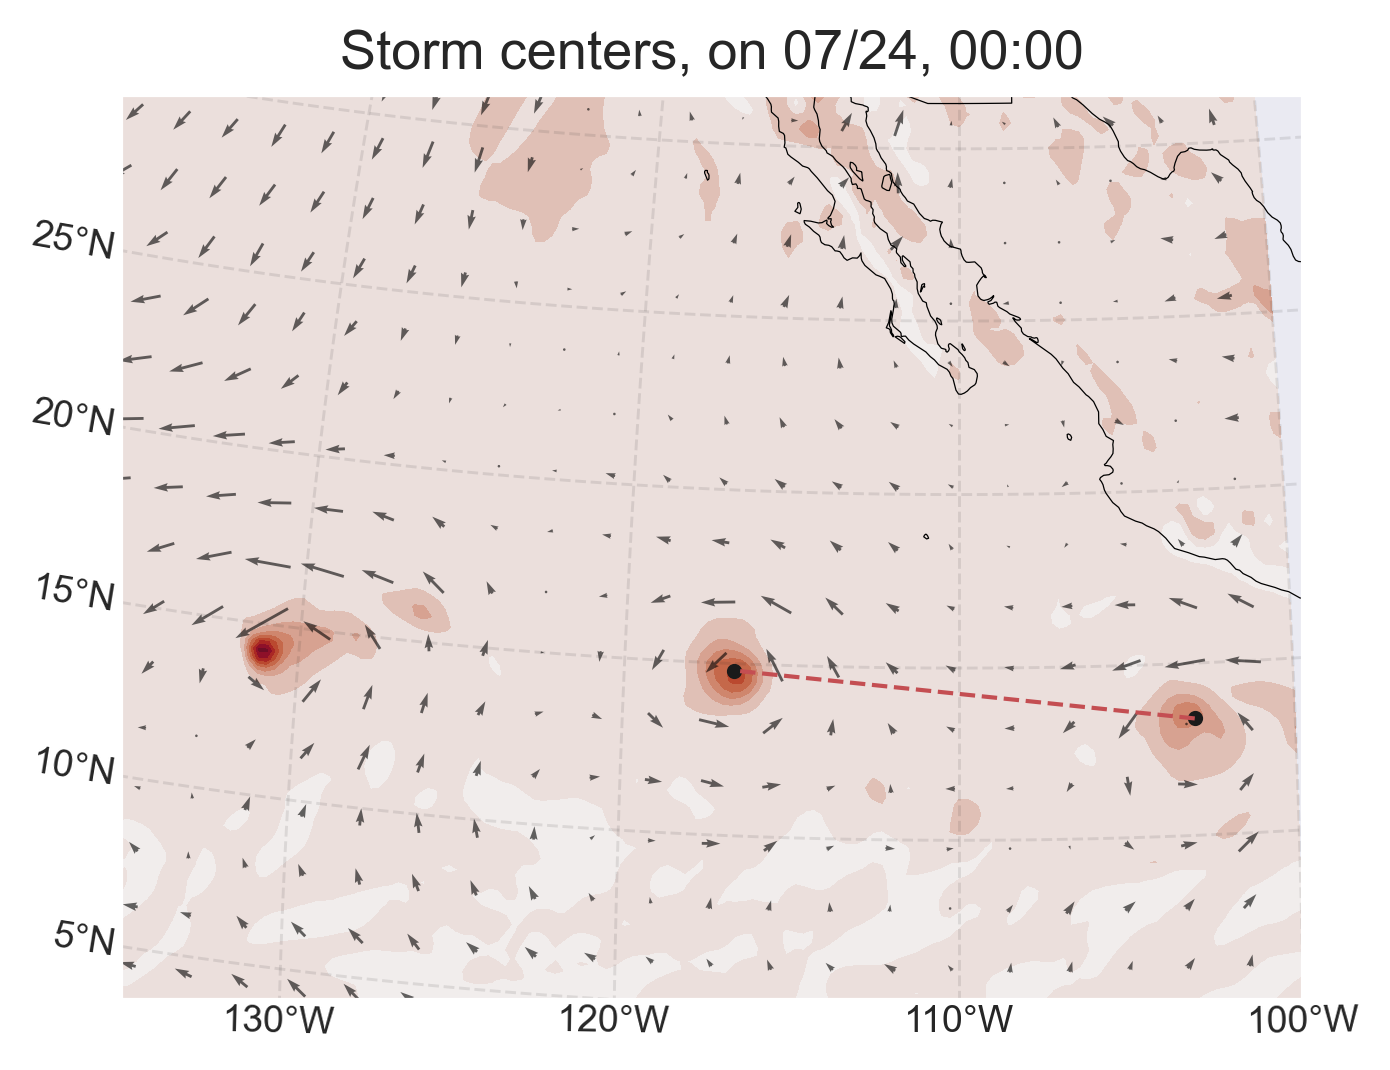

In [185]:
fig,ax = plot_frame(16, lev=1)
# ax.scatter(-120,20, color='k', transform=ccrs.PlateCarree())
plt.show()

Make animation figures

In [323]:
for t in progressbar(range(len(u.time))):
    fig,ax = plot_frame(t)
    fig.savefig(join(figs_fp, f'850_track_pretty_{t:03d}.png'), bbox_inches='tight')
    plt.close(fig)

100% (48 of 48) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


Tracking?

In [4]:
idx = np.argsort(zeta.isel(level=1,time=0).stack(n=['latitude','longitude']).values)
zeta.isel(level=1,time=0).stack(n=['latitude','longitude']).values[idx[-5:]]

KeyError: 'latitude'

# Estimate distance between vortices

In [326]:
R          = 6.37e6 # radius of earth
dtheta_deg = 6
r          = 2*np.pi*R * dtheta_deg/360 # estimated distance between vortices

# gamma_h = 18762935 # m^2/s
# gamma_i = 20461242
gamma_h = 2.0e7
gamma_i = 2.0e7
print(f'Percent difference: {100*(gamma_h-gamma_i)/gamma_h:.2f}%')

gamma = .5*(gamma_h+gamma_i)

# estimated translation speed:
speed_h = gamma_i / (2*np.pi*r)
speed_i = gamma_h / (2*np.pi*r)

# print(f'Speed: {speed:.2f} m/s')
print(f'Hilary speed: {speed_h:.2f} m/s')
print(f'Irwin speed:  {speed_i:.2f} m/s')

Percent difference: 0.00%
Hilary speed: 4.77 m/s
Irwin speed:  4.77 m/s


## distance between storms

In [30]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6.367e6 * c
    return m

## Velocities of storm centers

#### Compute $\Delta x$ and $\Delta y$ for each timestep, in km

In [163]:
dx = {'hilary':[],'irwin':[]}
dy = {'hilary':[],'irwin':[]}

for storm in ['hilary','irwin']:
    track = deepcopy(arr.sel(storm=storm))
    for ti,t in enumerate(track.time[:-1]):    
        y = track.isel(time=[ti,ti+1]).sel(var_='lat').values
        x = track.isel(time=[ti,ti+1]).sel(var_='lon').values
        dx[storm].append(haversine_np(x[0],y.mean(),x[1],y.mean()))
        dy[storm].append(haversine_np(x.mean(),y[0],x.mean(),y[1]))
        
deltas = xr.DataArray(np.stack([np.stack([dx['irwin'],dx['hilary']],axis=1), 
                      np.stack([dy['irwin'],dy['hilary']],axis=1)],axis=2),
                      coords= {'time':track.time[:-1],'delta':['dx','dy'], 'storm':['irwin','hilary']},
                      dims=['time','storm', 'delta'])
velocities        = deltas / (3600*6) # compute velocity based on 6 hour time differences
relative_velocity = velocities.sel(storm='hilary') - velocities.sel(storm='irwin')
relative_speed    = np.sqrt((relative_velocity**2).sum('delta'))
relative_speed.values[relative_speed==0]=np.nan

Include relative velocity on this plot!

/home/theo/miniconda3/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


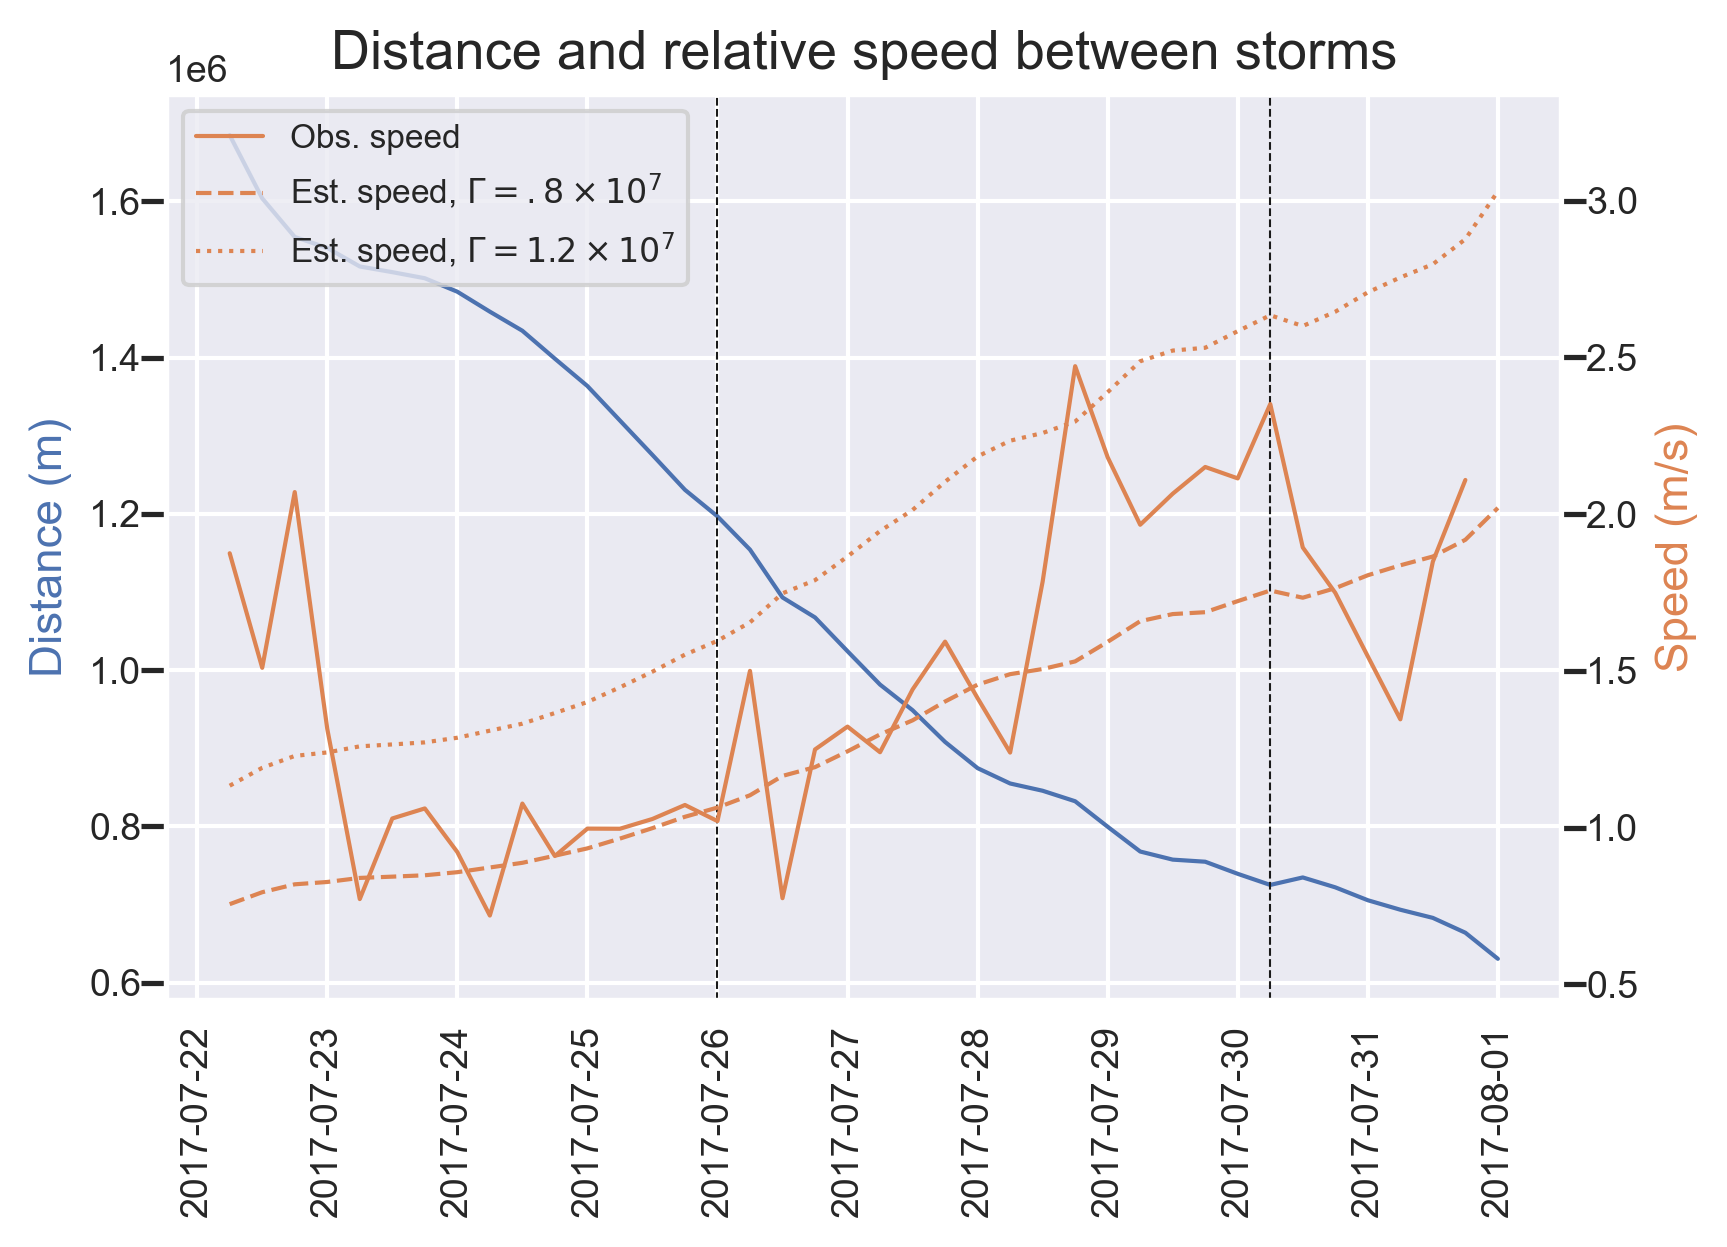

In [196]:
gamma=.8e7
r = haversine_np(arr.sel(storm='hilary', var_='lon').values,
                 arr.sel(storm='hilary', var_='lat').values,
                 arr.sel(storm='irwin', var_='lon').values,
                 arr.sel(storm='irwin', var_='lat').values)

# s = gamma / (2*np.pi*r) # speed calculation

fig,ax=plt.subplots()
ax.set_title('Distance and relative speed between storms')
colors = seaborn.color_palette()
c0,c,c2 = colors[:3]
ax.plot(arr.time, r)
ax.set_ylabel('Distance (m)', color=c0)
ax.set_xticklabels(ax.get_xticks(), rotation = 90)
ax.axvline(datetime(2017,7,26),ls='--',c='k',lw=.5)
ax.axvline(datetime(2017,7,30,6),ls='--',c='k',lw=.5)

ax2 = ax.twinx()
ax2.grid(False)
ax2.plot(relative_speed.time, relative_speed/2, color=c, label ='Obs. speed')
ax2.plot(arr.time, .8e7 / (2*np.pi*r),  color=c, ls='--', label=r'Est. speed, $\Gamma=.8\times10^7$')
ax2.plot(arr.time, 1.2e7 / (2*np.pi*r), color=c, ls=':',  label=r'Est. speed, $\Gamma=1.2\times10^7$')
ax2.set_ylabel('Speed (m/s)', color=c)  # we already handled the x-label with ax1
ax2.set_yticks(np.arange(.5,3.5,.5))
ax2.set_ylim([.45,3.34])
ax2.legend()
plt.show()

In [212]:
((2*np.pi**2*r[22:40]**2)/1e12).mean()

16.650349368795766

In [194]:
gamma = 1.0e12
r     = 1e6
T     = (2*np.pi**2*r**2) / gamma
print(T)

19.739208802178716


# Meridional cross sections

In [9]:
data = xr.open_dataset(join(data_fp, 'gfs.20170728_31.0p25.anl.nc'))
data['plev'] = data.plev/100

# compute potential temperature
RdCp = 0.286
Po = 1000 * 100 # 1000 mbar
theta = data['t']*(data.plev.values[-1]/(data.plev)) ** RdCp
data['theta'] = theta

## Compute vorticity (again...)

In [234]:
u = deepcopy(data['u'])
v = deepcopy(data['v'])

## Convert to polar coords
lon            = deepcopy(u.lon) # copy of original coords for plotting
lat            = deepcopy(u.lat)
theta          = np.deg2rad(u.lat).values
phi            = np.deg2rad(u.lon).values
u              = u.rename({'lon':'phi', 'lat':'theta'})
v              = v.rename({'lon':'phi', 'lat':'theta'})
u['phi']       = phi
v['phi']       = phi
u['theta']     = theta
v['theta']     = theta

# Compute vorticity

R     = 6.37e6
omega = 7.29e-5 
f     = 2*omega * np.sin(u['theta'])
f=0

## Relative vorticity
dv_dphi             = -v.differentiate('phi')
u_cos_theta         =  u * np.cos(u['theta'])

dtheta_du_cos_theta = -u_cos_theta.differentiate('theta')
zeta                = 1 / (R*np.cos(u['theta'])) * (dtheta_du_cos_theta - dv_dphi)

## Absolute vorticity
eta                 = zeta + f

eta['theta'] = data['lat'].values
eta['phi']   = data['lon'].values
eta = eta.rename({'theta':'lat', 'phi':'lon'})
data['eta'] = eta.transpose('time','plev','lat','lon')

In [225]:
f2 = 2*omega*np.sin(np.deg2rad(23))
f1 = 2*omega*np.sin(np.deg2rad(17))
print(f2-f1)

1.4340803985161095e-05


In [219]:
beta = 2*omega / R * np.cos(np.deg2rad(17))
beta = beta*(3600*24)
beta = beta * 1e6
print(f'{beta:.2e}')

1.89e+00


## Plotting

In [235]:
def get_meri_section(t, storm, name='u', delta=3, new_lat=False, use_km=True):
    '''Get meridional cross-section of a given storm'''
    posn         = [arr.sel(time=t, var_=x, storm=storm).values.item() for x in ['lon','lat']]
    # compute nearest gridpoint to actual storm center
    lat_         = np.round(posn[1]*4)/4
    lon_         = np.round((360+posn[0])*4)/4
    trimmed_data = data.sel(time=t, lon=lon_, lat=slice(lat_+delta, lat_-delta))
    if new_lat:
        len_  = len(trimmed_data['lat'])
        d    = haversine_np(0,0,0,delta)/1e3 if use_km else delta
        step  = (2*d)/(len_-1)
        new_lat = np.arange(d, -d-step, -step)
        trimmed_data['lat'] = new_lat
    return trimmed_data

def plot_cross_section(t, name='u', delta=3, storm='hilary'):
    if name=='u':
        levels = gen_utils.make_cb_range(30,3)
        cmap = 'cmo.balance'
    elif name=='theta':
        levels = np.arange(300,370,5)
        cmap = 'cmo.thermal'
    elif name=='eta':
        levels = np.arange(0,16,1)
        cmap = 'cmo.amp'
    plot_data = get_meri_section(t, storm=storm, name=name, delta=delta)[name]
    fig,ax = plt.subplots(figsize=(6,4))
    cp = ax.contourf(data.lat.sel(lat=slice(posn[1]+delta, posn[1]-delta)), data.plev, 1e4*plot_data,
               cmap=cmap, levels=levels, extend='both')
    cb = fig.colorbar(cp, orientation='vertical', label=r'$f+\zeta$ ($10^{-4}$ m/s)')
    
    # Add u-contours
#     plot_data2 = data.sel(time=t, lon=lon_, lat=slice(posn[1]+delta, posn[1]-delta))['u']
#     cp2 = ax.contour(data.lat.sel(lat=slice(posn[1]+delta, posn[1]-delta)), data.plev, plot_data2,
#                colors='k', levels=gen_utils.make_cb_range(30,6), extend='both')
    
    # Add theta-contours
    plot_data2 = data.sel(time=t, lon=lon_, lat=slice(posn[1]+delta, posn[1]-delta))['theta']
    cp2 = ax.contour(data.lat.sel(lat=slice(posn[1]+delta, posn[1]-delta)), data.plev, plot_data2,
               colors='k', levels=np.arange(300,500,5), extend='both')
    
    ax.set_ylim([100,None])
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_ylabel('Pressure (hPa)')
    ax.set_xlabel('Latitude ($^{\circ}N$)')
    mo = t.dt.month.values.item()
    da = t.dt.day.values.item()
    ho = t.dt.hour.values.item()
    title = r'Vertical profile on ' + f'{mo:02d}/{da:02d}, {ho:02d}:00'
    ax.set_title(title)
    return fig, ax

TypeError: Length of x (40) must match number of columns in z (41)

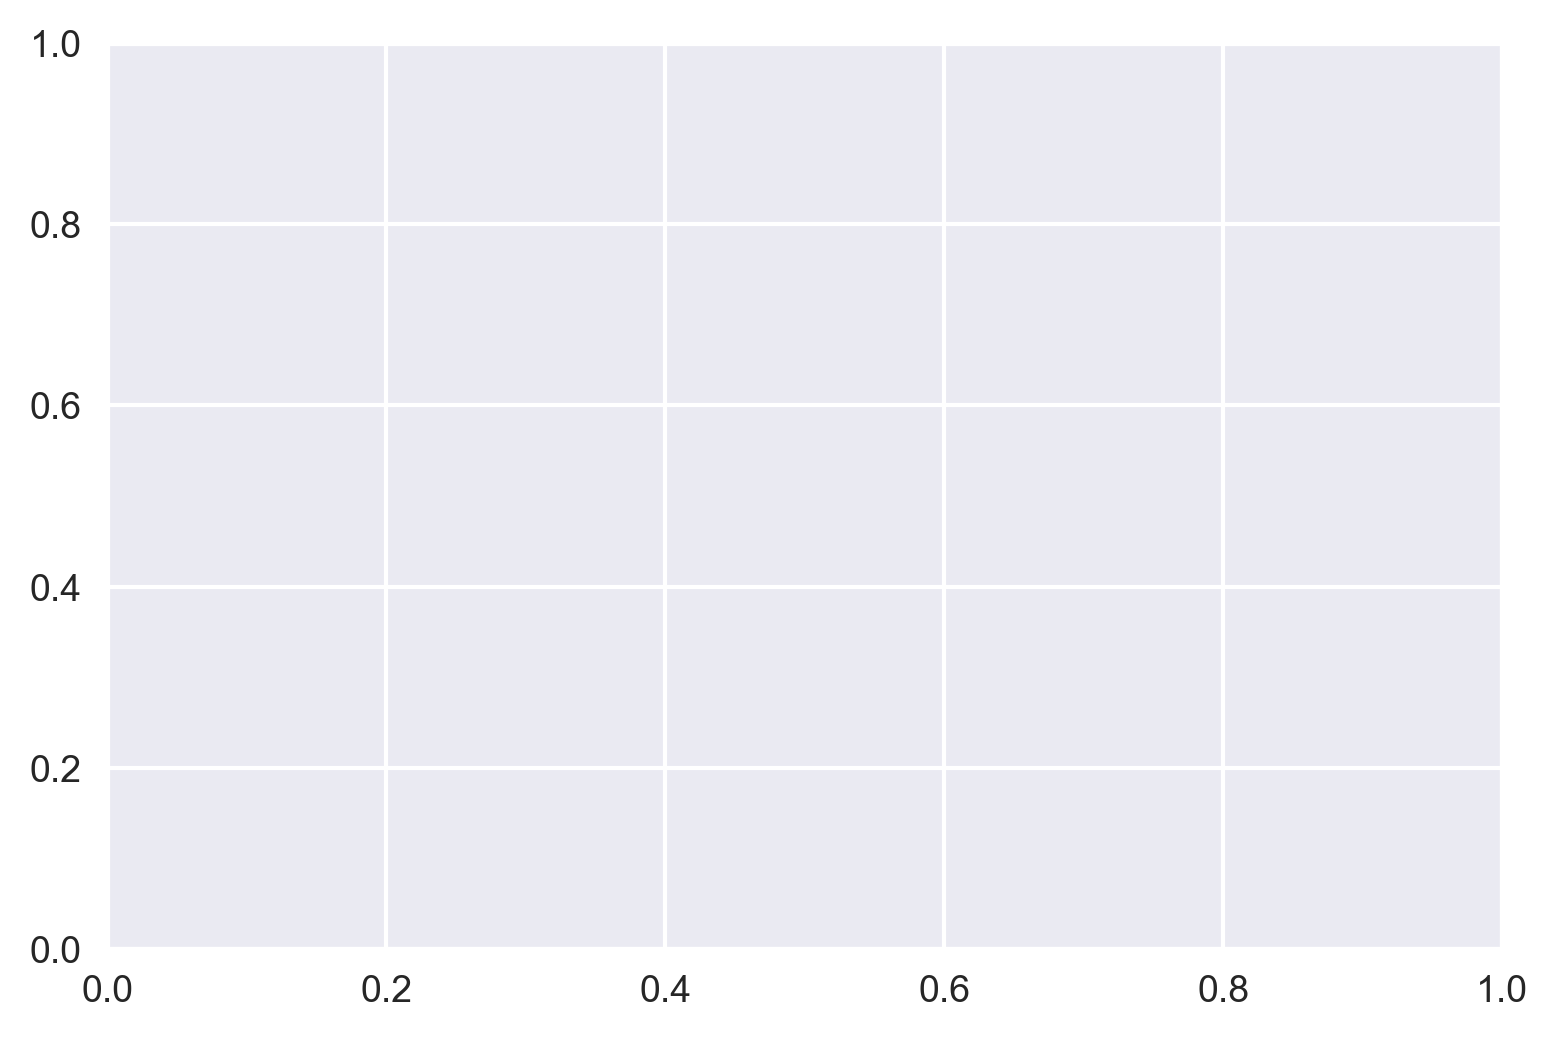

In [236]:
# single plot
valid_times = data.time
t = valid_times[3]
fig,ax = plot_cross_section(t, delta=5, name='eta', storm='irwin')
plt.show()

### Plots for animation
# for i,t in progressbar(enumerate(valid_times)):
#     fig,ax = plot_cross_section(t, name='eta',delta=4, storm='irwin')
#     fig.savefig(join(figs_fp, f'cross_section-irwin-vorticity_{i:03d}.png'), bbox_inches='tight')
#     plt.close(fig)

# Create Lagrangian time-average plots

In [314]:
delta = 10
hilary_cross = xr.concat([get_meri_section(t, storm='hilary',new_lat=True,delta=delta)
                          for t in valid_times], dim='time')

irwin_cross = xr.concat([get_meri_section(t, storm='irwin',new_lat=True,delta=delta)
                          for t in valid_times], dim='time')

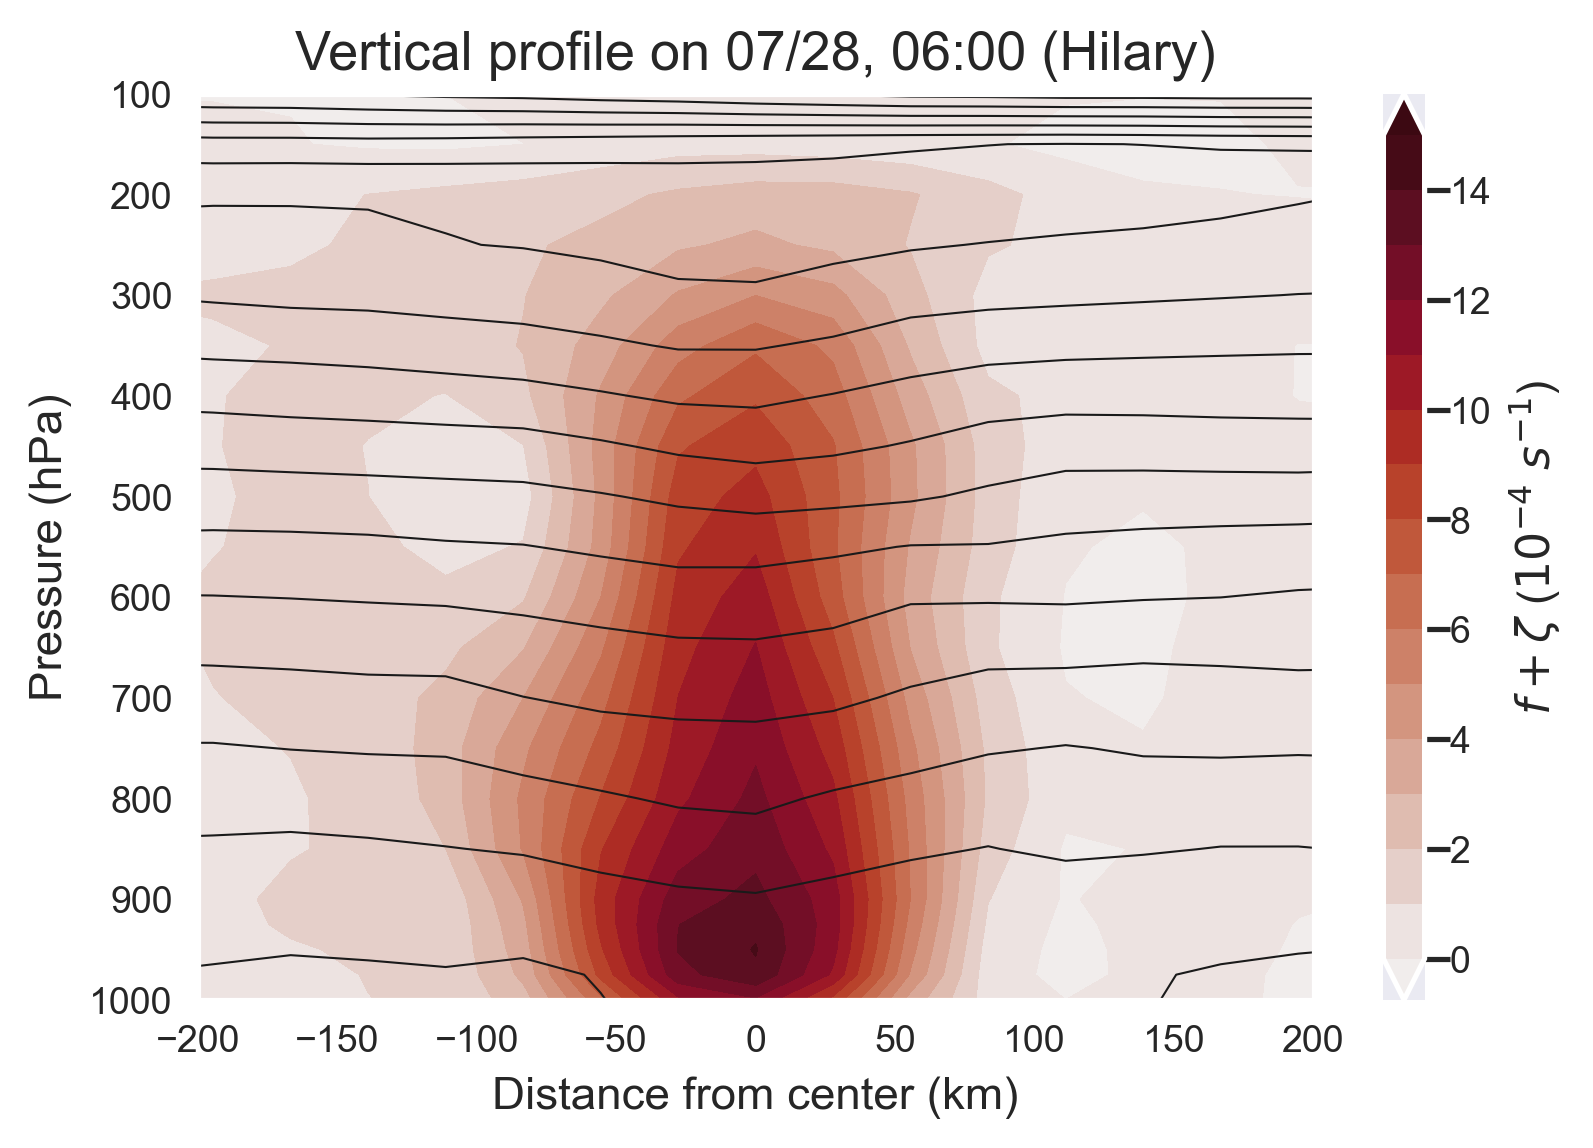

In [315]:
n = 'Hilary' # storm to plot
ti= 1            # time index to plot

s = hilary_cross if n=='Hilary' else irwin_cross
t = s.time[ti]

fig,ax = plt.subplots(figsize=(6,4))

## Velocity
# cp = ax.contourf(s.lat, s.plev, s['u'].sel(time=t),
#            cmap='cmo.balance', levels=gen_utils.make_cb_range(30,3), extend='both')
# cb = fig.colorbar(cp, orientation='vertical', label=r'Velocity (m/s)')

# ## Vorticity
cp = ax.contourf(s.lat, s.plev, 1e4*s['eta'].sel(time=t),
           cmap='cmo.amp', levels=np.arange(0,16,1), extend='both')
cb = fig.colorbar(cp, orientation='vertical', label=r'$f+\zeta$ ($10^{-4}$ $s^{-1}$)')

## Add theta-contours
cp2 = ax.contour(s.lat, s.plev, s['theta'].sel(time=t),
           colors='k', levels=np.arange(300,500,5), extend='both')

ax.set_ylim([100,None])
ax.set_xlim([-200,200])
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Distance from center (km)')
mo = t.dt.month.values.item()
da = t.dt.day.values.item()
ho = t.dt.hour.values.item()
title = r'Vertical profile on ' + f'{mo:02d}/{da:02d}, {ho:02d}:00 ({n})'
ax.set_title(title)
plt.show()

Theory: assume
- radius of circle = 50km = 5e4 m
- vorticity anomaly = 10 $\times 10^{-4}s^{-1}$  
$\Gamma = \int \zeta dA$

Vorticity-based estimate: 1.18e+07 m^2/s
Velocity-based estimate:  9.42e+06 m^2/s
(40,)


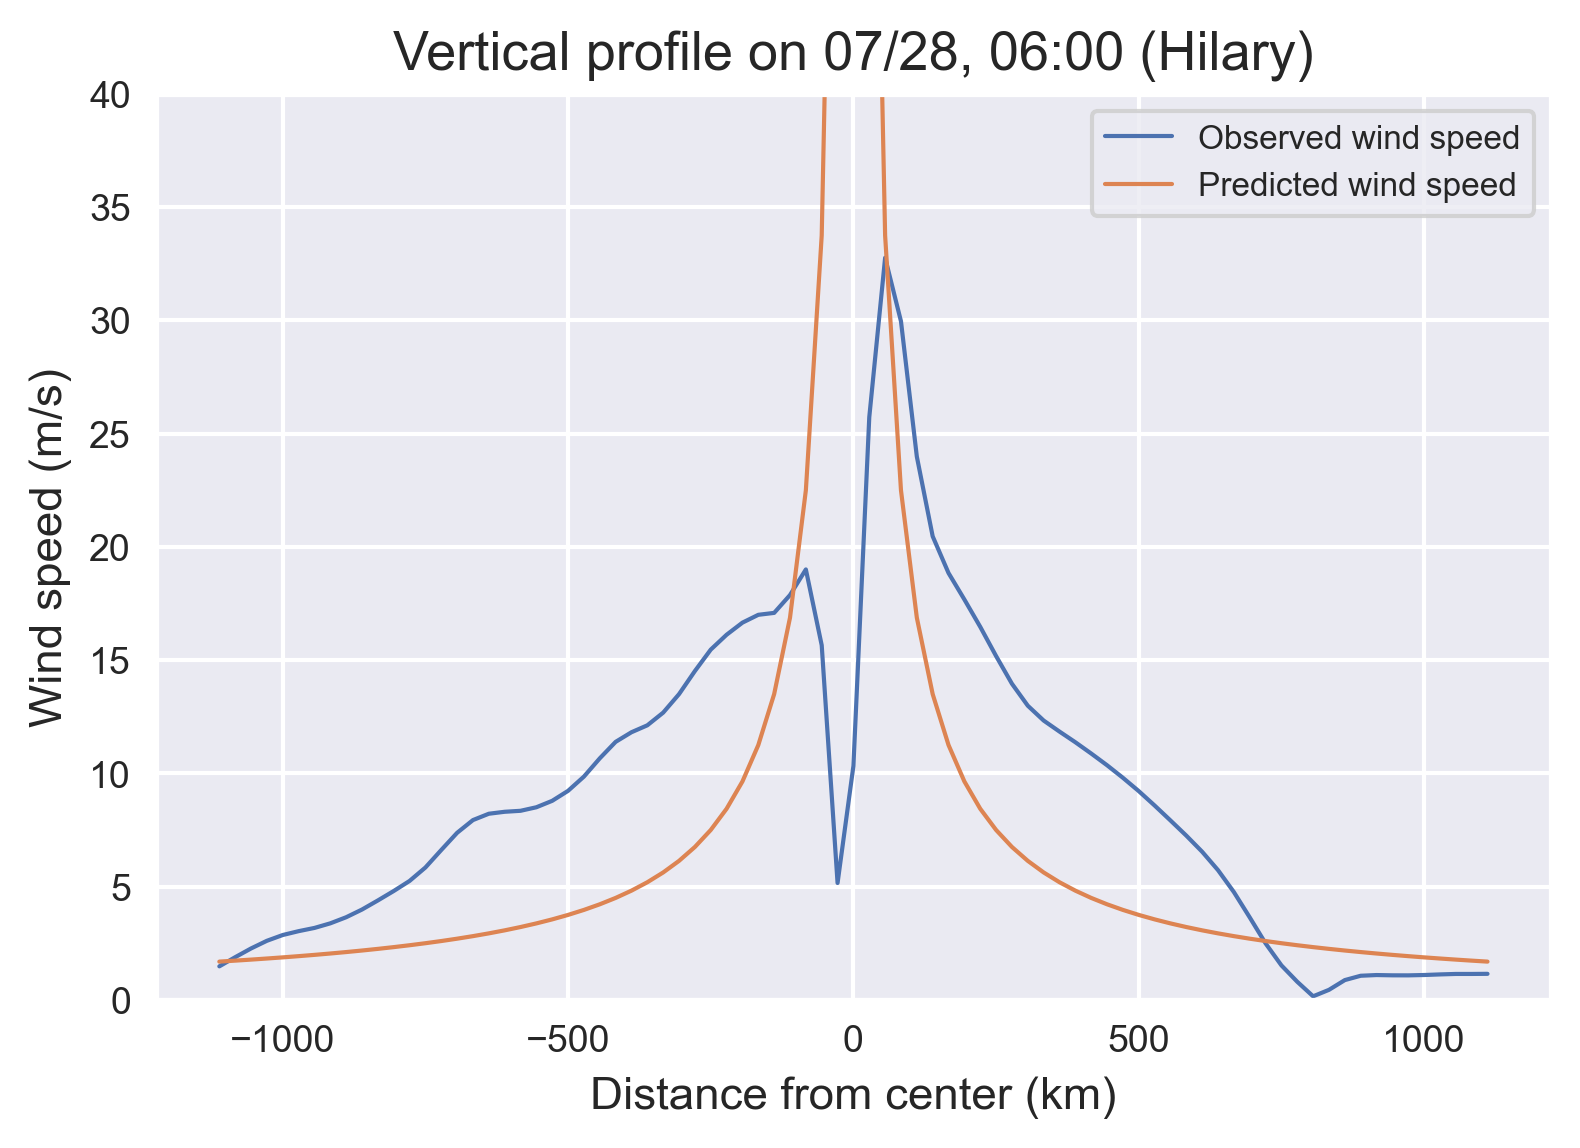

In [324]:
# plt.plot(np.abs(s.sel(time=t, plev=slice(700,None)).mean('plev')['u']))

n = 'Hilary' # storm to plot
ti= 1            # time index to plot

s = hilary_cross if n=='Hilary' else irwin_cross
t = s.time[ti]

# compute theoretical speed
radius    = 50e3
area      = np.pi * (radius)**2
zeta_anom = 1.5e-3
gamma     = area*zeta_anom
print(f'Vorticity-based estimate: {gamma:.2e} m^2/s')
print(f'Velocity-based estimate:  {2*np.pi*radius * 30:.2e} m^2/s')


est_speed = gamma/(2*np.pi*s.lat[:int(len(s.lat)/2)]*1000).values
print(est_speed.shape)
est_speed = np.concatenate([est_speed, np.array(np.max(est_speed))[None], est_speed[::-1]])

fig,ax = plt.subplots(figsize=(6,4))

## speed
cp = ax.plot(s.lat, np.abs(s.sel(time=t, plev=slice(700,None)).mean('plev')['u']), label='Observed wind speed')
cp = ax.plot(s.lat, est_speed, label='Predicted wind speed')
# cp = ax.plot(s.lat, np.abs(s.sel(time=t, plev=slice(700,None)).mean('plev')['u']))

ax.set_ylabel('Wind speed (m/s)')
ax.set_xlabel('Distance from center (km)')
ax.set_ylim([0,40])
mo = t.dt.month.values.item()
da = t.dt.day.values.item()
ho = t.dt.hour.values.item()
title = r'Vertical profile on ' + f'{mo:02d}/{da:02d}, {ho:02d}:00 ({n})'
ax.set_title(title)
ax.legend()
plt.show()

### Computations

In [197]:
Omega = 2*np.pi / (3600*24)
f = 2*Omega * np.sin(np.deg2rad(18))
U = 20
L = 200e3
print(U/(f*L))

2.2249564479380908
